Ce calepin regroupe des traitements ayant abouti à **[une cartographie du prix médian du m²](https://www.rue89lyon.fr/2021/09/20/immobilier-evolution-prix-metropole-lyon/)** (ventes d'appartements et de maisons entre 2016 et 2020) pour Rue89 Lyon.

![carte_immo_lyon](app_immolyo.jpg)

On s'est servi pour cela **[des fichiers de demandes de valeurs foncières géolocalisées](https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres-geolocalisees/)**, trouvables sur le portail DataGouv.

On clôture en beauté avec la constitution **d'une classe Python basée sur une première exploration** et la jointure avec des données géographiques. 

Pour faire gagner du temps aux plus impatients, cette classe et l'exemple lyonnais sont directement **disponibles dans le fichier py voisin de ce calepin**.

# Une première exploration

Le premier enjeu va être de jeter un coup d'oeil à des premières données, l'histoire de savoir un peu où on met les pieds et de faire quelques choix.

Donc, on entame par les incontournables imports de modules :

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

On d'abord se concentrer sur l'année 2020, et faire un premier tour d'horizon. En langage pandas, cela signifie : 
* nouvelle DataFrame 
* affichage des cinq premières lignes

In [2]:
mut_2020 = pd.read_csv("https://files.data.gouv.fr/geo-dvf/latest/csv/2020/full.csv.gz",low_memory=False)
mut_2020.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2020-1,2020-01-07,1,Vente,8000.0,NaN,NaN,FORTUNAT,B063,1250.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,1061.0,5.323540,46.171919
1,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,TERRES DES CINQ SAULES,B124,1290.0,...,NaN,NaN,NaN,BT,taillis simples,NaN,NaN,85.0,4.893436,46.251868
2,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,BOIS DU CHAMP RION,B006,1290.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,1115.0,4.899919,46.235327
3,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,EN COROBERT,B025,1290.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,1940.0,4.882347,46.246519
4,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,TERRES DES CINQ SAULES,B124,1290.0,...,NaN,NaN,NaN,T,terres,NaN,NaN,1148.0,4.894688,46.251820


Beaucoup de NaN, et de colonnes pas forcément utiles... On va les lister afin de faire notre marché :

In [3]:
mut_2020.columns

Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude'],
      dtype='object')

Et ne retenir que celles qui nous intéressent le plus (avec une attention particulière portée sur valeur_fonciere et surface_reelle_bati) :

In [4]:
mut_2020=mut_2020[['id_mutation', 'nature_mutation', 'code_commune', 'nom_commune', 'code_departement',
                   'id_parcelle', 'ancien_id_parcelle', 'code_type_local', 'type_local', 
                   'valeur_fonciere','surface_reelle_bati', 'surface_terrain', 'longitude', 'latitude']]

mut_2020.head()

,id_mutation,nature_mutation,code_commune,nom_commune,code_departement,id_parcelle,ancien_id_parcelle,code_type_local,type_local,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude
0,2020-1,Vente,01072,Ceyzériat,01,01072000AK0216,NaN,NaN,NaN,8000.0,NaN,1061.0,5.323540,46.171919
1,2020-2,Vente,01203,Laiz,01,012030000B0004,NaN,NaN,NaN,2175.0,NaN,85.0,4.893436,46.251868
2,2020-2,Vente,01203,Laiz,01,012030000B0173,NaN,NaN,NaN,2175.0,NaN,1115.0,4.899919,46.235327
3,2020-2,Vente,01203,Laiz,01,012030000B0477,NaN,NaN,NaN,2175.0,NaN,1940.0,4.882347,46.246519
4,2020-2,Vente,01203,Laiz,01,012030000C0068,NaN,NaN,NaN,2175.0,NaN,1148.0,4.894688,46.251820


C'est déjà mieux, mais on observe une répétition de **l'id 2020-2**, soit plusieurs parcelles cadastrales incluses dans la même vente. Cela peut regrouper notamment :

* **un bien principal et une ou plusieurs petites parcelles** autour, qu'une commune peut demander à raboter lors de travaux de voirie par exemple. Pour le dire vite, une ligne avec une surface_reelle_bati, et les autres non
* un ensemble de biens de même nature, par exemple un lot de maisons. Dans ce cas précis, on peut se risquer à calculer le prix au m² en additionnant les surfaces
* un ensemble de biens de nature différentes : maison+appartement, maison+local industriel, appartement+local+dépendance... **C'est la foire aux cas particuliers**, et certains pourraient n'exclure que les combinaisons maison(s)+appartement(s)

Dans notre cas, on va faire très radical, en ne retenant dans cette BDD que les id_mutation strictement uniques. En gros à partir de deux lignes, on vire. Ca ne retiendra pas toutes les transactions, **mais on peut le justifier** car le calcul du prix au m² sera dans ce cas limpide.

On va d'abord regarder la longueur de la DataFrame :

In [5]:
len(mut_2020)

2459560

Puis la ratiboiser en conséquence :

In [6]:
mut_2020.drop_duplicates(subset="id_mutation",keep=False,inplace=True,ignore_index=True)
mut_2020.head()

,id_mutation,nature_mutation,code_commune,nom_commune,code_departement,id_parcelle,ancien_id_parcelle,code_type_local,type_local,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude
0,2020-1,Vente,01072,Ceyzériat,01,01072000AK0216,NaN,NaN,NaN,8000.0,NaN,1061.0,5.323540,46.171919
1,2020-3,Vente,01289,Péronnas,01,01289000AI0210,NaN,NaN,NaN,75000.0,NaN,610.0,5.226198,46.184538
2,2020-6,Vente,01289,Péronnas,01,01289000AI0223,NaN,NaN,NaN,64000.0,NaN,530.0,5.224725,46.185710
3,2020-7,Vente,01053,Bourg-en-Bresse,01,01053000AI0138,NaN,1.0,Maison,180300.0,75.0,525.0,5.208916,46.196883
4,2020-8,Vente,01053,Bourg-en-Bresse,01,01053000BK0197,NaN,2.0,Appartement,54800.0,32.0,NaN,5.229867,46.206675


Et à vérifier que la DataFrame ne contient bien que des id de mutation uniques :

In [7]:
print(len(mut_2020), len(mut_2020["id_mutation"].unique()))

515782 515782


On a presque divisé la taille par cinq. Ce n'est pas rien, et on peut continuer à dérouler sans se préoccuper de cas particuliers. On va par exemple modifier les codes de communes et de départements afin de les rendre plus propre (avec des 0 au début pour les premiers de liste) :

In [8]:
mut_2020["code_commune"] = mut_2020["code_commune"].astype(str).str.rjust(5,"0")
mut_2020["code_departement"] = mut_2020["code_departement"].astype(str).str.rjust(2,"0")
mut_2020.head()

,id_mutation,nature_mutation,code_commune,nom_commune,code_departement,id_parcelle,ancien_id_parcelle,code_type_local,type_local,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude
0,2020-1,Vente,01072,Ceyzériat,01,01072000AK0216,NaN,NaN,NaN,8000.0,NaN,1061.0,5.323540,46.171919
1,2020-3,Vente,01289,Péronnas,01,01289000AI0210,NaN,NaN,NaN,75000.0,NaN,610.0,5.226198,46.184538
2,2020-6,Vente,01289,Péronnas,01,01289000AI0223,NaN,NaN,NaN,64000.0,NaN,530.0,5.224725,46.185710
3,2020-7,Vente,01053,Bourg-en-Bresse,01,01053000AI0138,NaN,1.0,Maison,180300.0,75.0,525.0,5.208916,46.196883
4,2020-8,Vente,01053,Bourg-en-Bresse,01,01053000BK0197,NaN,2.0,Appartement,54800.0,32.0,NaN,5.229867,46.206675


Et on peut désormais ne retenir que les transactions conclues dans le département du Rhône :

In [9]:
mut_69 = mut_2020[mut_2020["code_departement"]=="69"].copy().reset_index()
mut_69.drop(columns="index", inplace=True)
mut_69.tail()

,id_mutation,nature_mutation,code_commune,nom_commune,code_departement,id_parcelle,ancien_id_parcelle,code_type_local,type_local,valeur_fonciere,surface_reelle_bati,surface_terrain,longitude,latitude
10834,2020-700482,Vente,69234,Saint-Romain-de-Popey,69,692340000D0601,NaN,NaN,NaN,3000.0,NaN,7605.0,4.502136,45.863081
10835,2020-700483,Vente,69056,Chessy,69,69056000AM0082,NaN,1.0,Maison,320000.0,100.0,474.0,4.604383,45.885032
10836,2020-700484,Vente,69264,Villefranche-sur-Saône,69,69264000BC0084,NaN,1.0,Maison,250000.0,155.0,525.0,4.749664,45.977440
10837,2020-700488,Vente,69264,Villefranche-sur-Saône,69,69264000AL0069,NaN,4.0,Local industriel. commercial ou assimilé,77000.0,50.0,NaN,4.715294,45.986887
10838,2020-700490,Vente,69019,Belleville-en-Beaujolais,69,69019000AH0957,NaN,NaN,NaN,175000.0,NaN,126.0,NaN,NaN


Et plus précisément la vente d'un appartement ou d'une maison :

In [10]:
mut_69=mut_69[(mut_69["nature_mutation"]=="Vente") & (mut_69["type_local"].isin(["Appartement","Maison"]))]
print(len(mut_69))

7397


On va à présent visualiser la distribution de ces 7 397 ventes dans un espace à deux dimensions (une pour la valeur foncière, l'autre pour la surface) :

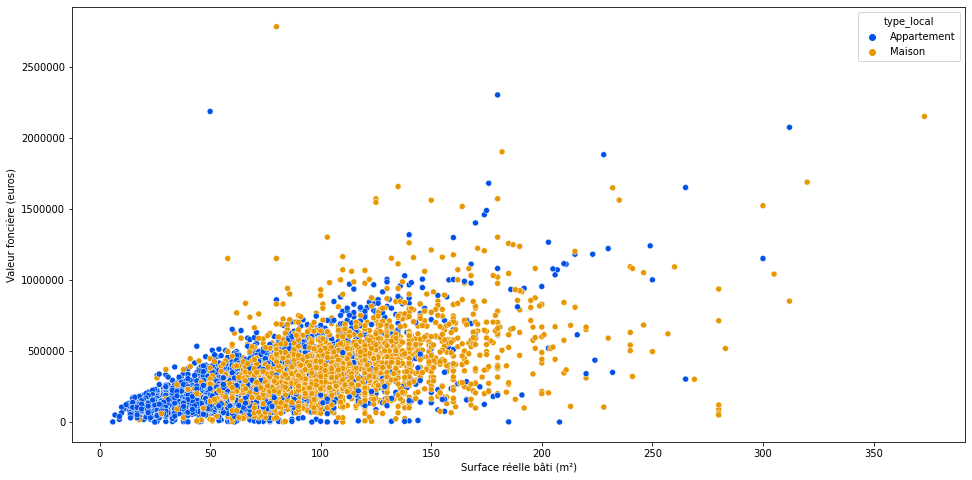

In [11]:
palette ={"Maison": "#e99700", "Appartement": "#0052e9"}
legende={"Maison": "#e99700", "Appartement": "#0052e9"}

fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(data=mut_69, x="surface_reelle_bati",y="valeur_fonciere", hue="type_local", palette=palette)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_ylabel("Valeur foncière (euros)")
ax.set_xlabel("Surface réelle bâti (m²)")
patches = [ ax.plot([],[], marker="o", ms=10, ls="", mec=None, color=legende[i], 
            label=i)[0]  for i in legende.keys()];

**Hormis quelques aberrations**, notamment un appartement et une maison très chers en comparaison de leur surface, ce nuage de points adopte une forme en cône assez caractéristique de ce type de données (un exemple [avec les maisons du Comté de King (Washington)](https://colab.research.google.com/drive/1NS-iLFbfe-eL_mC7HCw3keY1kkp-YevV?usp=sharing).

Le nombre de maisons et d'appartements semble équivalent, mais cela risque de changer en ne considérant que les ventes actées dans la Métropole de Lyon. On va rapido scraper les villes qui en font partie [sur la page Wikipedia dédiée](https://fr.wikipedia.org/wiki/M%C3%A9tropole_de_Lyon) :

In [12]:
# il suffit juste de paramétrer une liste vide qui va abriter l'ensemble des noms
metropole_lyon=[]
url = "https://fr.wikipedia.org/wiki/M%C3%A9tropole_de_Lyon"
url = requests.get(url)

soupe = BeautifulSoup(url.text, "lxml")
tableau = soupe.find("table", {"class":"wikitable sortable"})
lignes = tableau.findAll("tr")
# à chaque ligne, si les infos d'une ville existe, on sélectionne le deuxième élément pour le glisser dans notre liste
for ligne in lignes:
    info_ville = ligne.findAll("td")
    if info_ville:
        metropole_lyon.append(info_ville[1].get_text().replace("\n",""))

print(len(metropole_lyon))

59


Un petit détour pour bien paramétrer les arrondissements de Lyon :

In [13]:
# on réserve les communes strictes de la métropole pour plus tard !
# attention au [:] pour bien entériner une copie de metropole_lyon (et non une référence)
com_mlyon = metropole_lyon[:]

# et on crée une liste avec les codes INSEE de chaque arrondissement lyonnais
insee_lyon = []
for i in range(1,10):
    insee_lyon.append("6938"+str(i))

metropole_lyon.remove("69123")
metropole_lyon.extend(insee_lyon)

print(len(com_mlyon), len(metropole_lyon))

59 67


Cette nouvelle variable peut être utilisée pour filtrer la DataFrame du Rhône :

In [14]:
mut_mlyon = mut_69[mut_69["code_commune"].isin(metropole_lyon)]
mut_mlyon.dropna(subset=["valeur_fonciere","surface_reelle_bati"], inplace=True)
len(mut_mlyon)

c:\users\rapha\appdata\local\programs\python\python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


5662

Et on visualise :

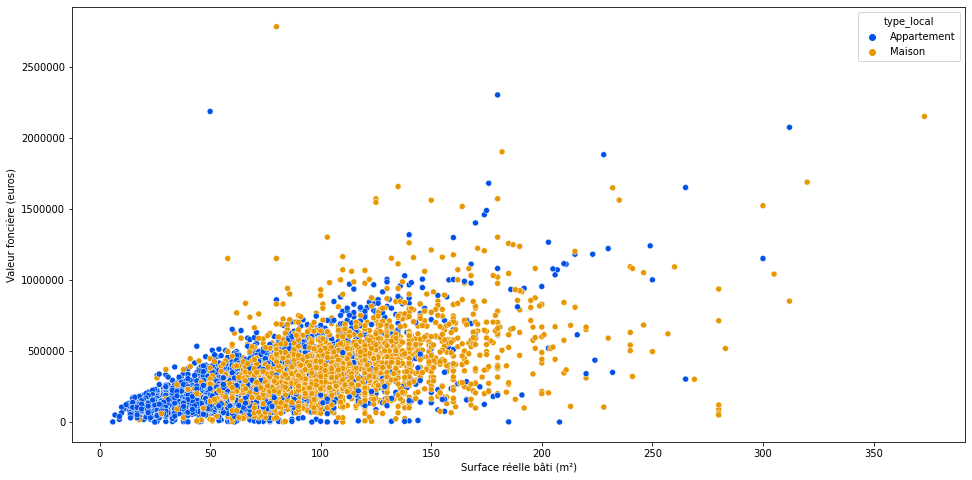

In [15]:
fig, ax = plt.subplots(figsize=(16,8))

sns.scatterplot(data=mut_69, x="surface_reelle_bati",y="valeur_fonciere", hue="type_local", palette=palette)
ax.get_yaxis().get_major_formatter().set_scientific(False)
ax.set_ylabel("Valeur foncière (euros)")
ax.set_xlabel("Surface réelle bâti (m²)")
patches = [ ax.plot([],[], marker="o", ms=10, ls="", mec=None, color=legende[i], 
            label=i)[0]  for i in legende.keys()];

Désormais plus d'appartements que de maisons, ce qui est assez raccord avec le marché immobilier d'une grande métropole :

In [16]:
mut_mlyon["type_local"].value_counts()

Appartement    4360
Maison         1302
Name: type_local, dtype: int64

Et maintenant ? Maintenant on peut calculer le prix au m² dans une nouvelle colonne...

In [17]:
mut_mlyon["prix_m2"]=round(mut_mlyon["valeur_fonciere"].astype(float)/mut_mlyon["surface_reelle_bati"].astype(float)).astype(int)

c:\users\rapha\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Et à visualiser la distribution des prix de chaque ville (tous types de bien confondus) :

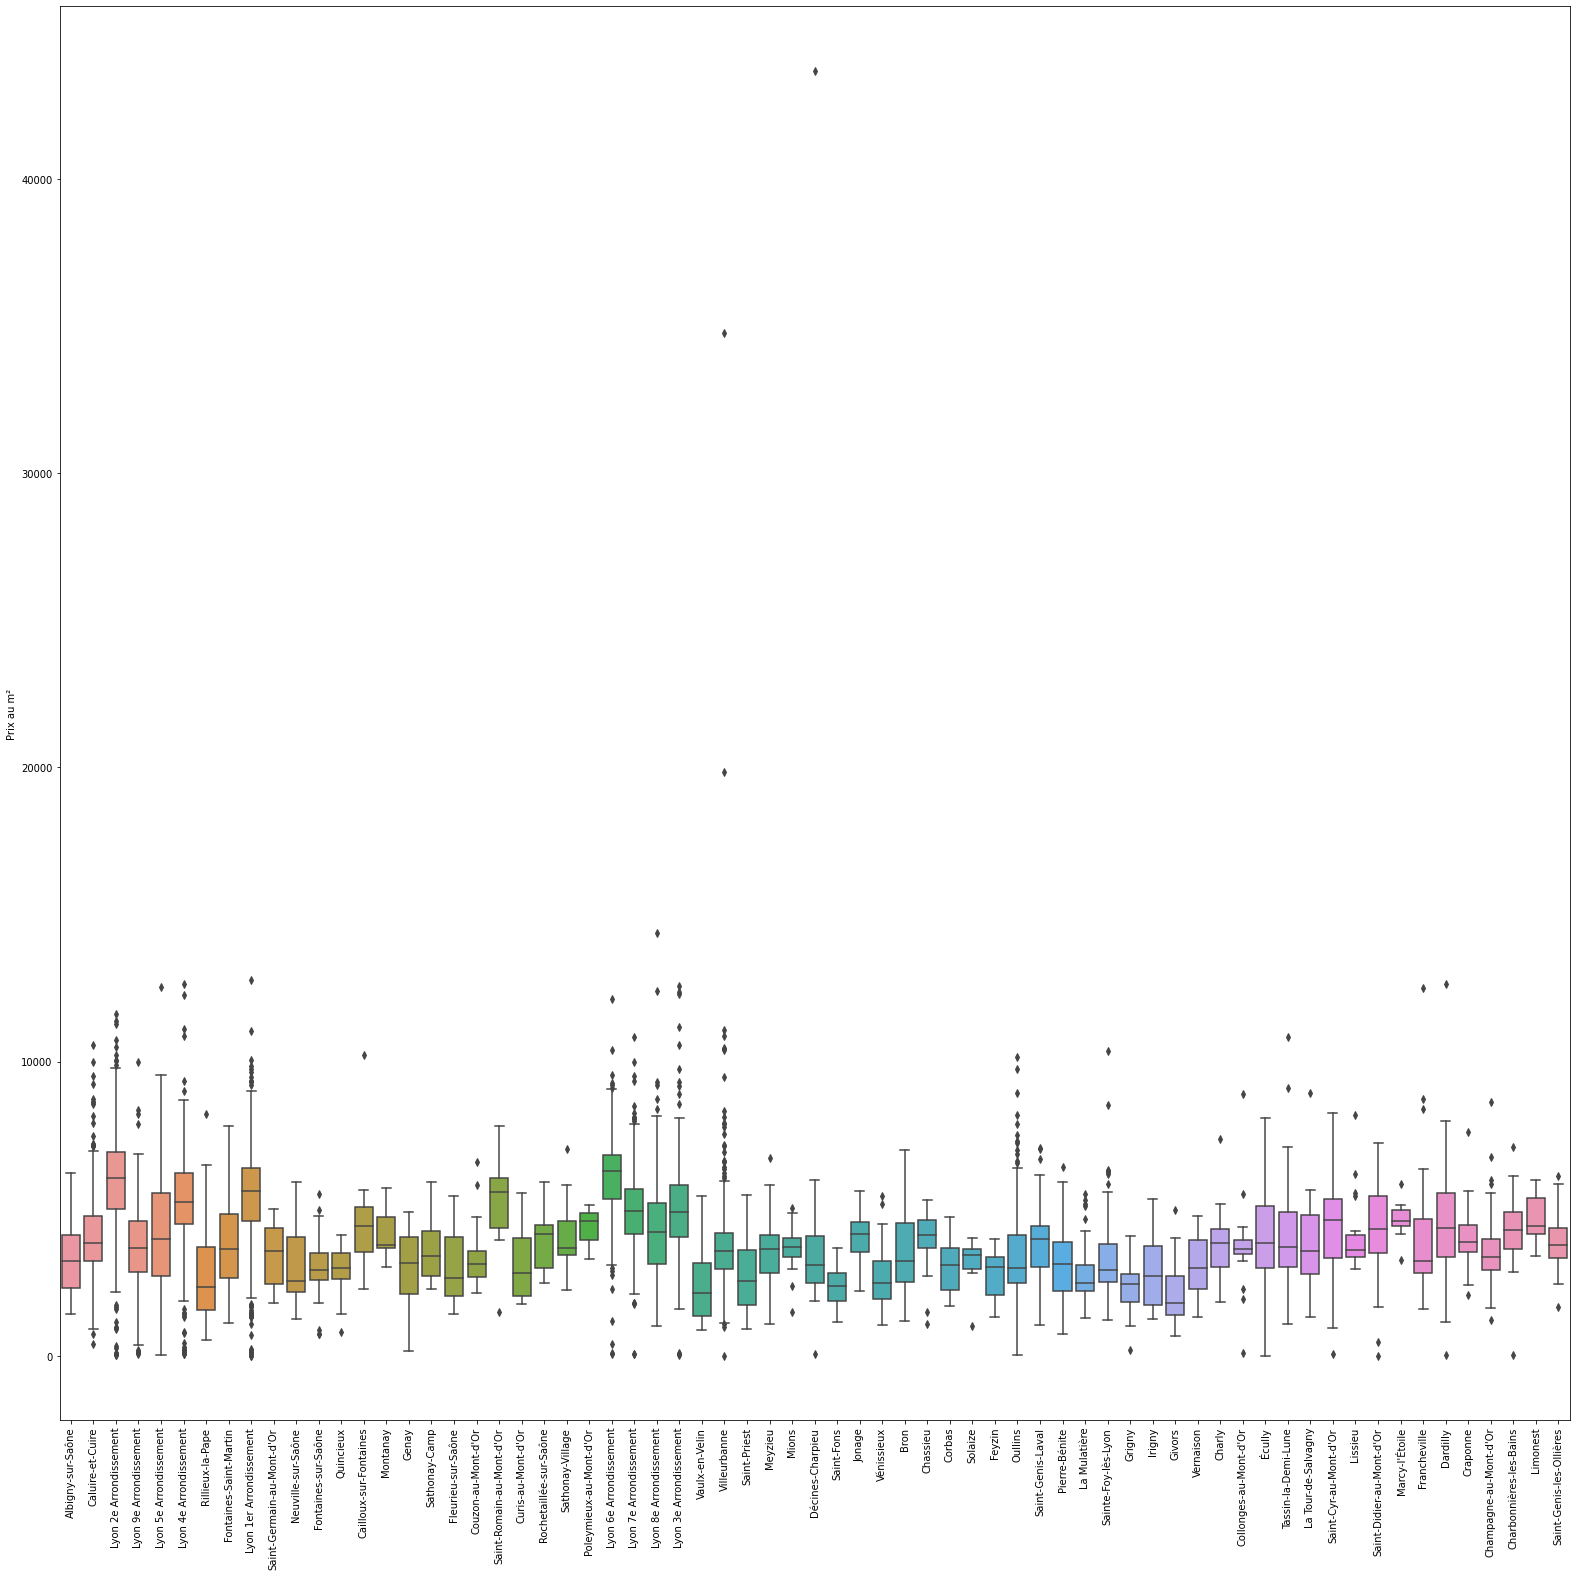

In [18]:
fig, ax = plt.subplots(figsize=(22,22))

sns.boxplot(x="nom_commune", y="prix_m2", data=mut_mlyon,ax=ax)
ax.set_ylabel("Prix au m²")
ax.set_xlabel("")
ax.xaxis.set_tick_params(rotation=90)
fig.tight_layout();

Pour le dire vite, **chaque "boîte" de ce graphique contient la moitié des effectifs**, bornées au premier au dernier quartile, et la ligne qui découpe chaque boîte en deux correspond à la médiane. 

Les points hors "des moustaches" **sont considérées comme des aberrations**, et on remarque trois d'entre elles particulièrement sévères (et observées dans le graphique précédent).

On peut très rapidement **mesurer l'effet de ces ventes sur la moyenne** des villes concernées, en regardant les valeurs originales :

In [19]:
print("Médianes\nVilleurbane :",mut_mlyon[mut_mlyon["nom_commune"]=="Villeurbanne"]["prix_m2"].median(),"\nDécines-Charpieu :",mut_mlyon[mut_mlyon["nom_commune"]=="Décines-Charpieu"]["prix_m2"].median())
print("-"*50)
print("Moyennes\nVilleurbane :",mut_mlyon[mut_mlyon["nom_commune"]=="Villeurbanne"]["prix_m2"].mean(),"\nDécines-Charpieu :",mut_mlyon[mut_mlyon["nom_commune"]=="Décines-Charpieu"]["prix_m2"].mean())

Médianes
Villeurbane : 3578.0 
Décines-Charpieu : 3074.5
--------------------------------------------------
Moyennes
Villeurbane : 3804.253438113949 
Décines-Charpieu : 3911.0862068965516


Et en les comparant après purge de ces ventes :

In [20]:
mut_mlyon= mut_mlyon[~(mut_mlyon["prix_m2"]>19000)]

print("Médianes\nVilleurbane :",mut_mlyon[mut_mlyon["nom_commune"]=="Villeurbanne"]["prix_m2"].median(),"\nDécines-Charpieu :",mut_mlyon[mut_mlyon["nom_commune"]=="Décines-Charpieu"]["prix_m2"].median())
print("-"*50)
print("Moyennes\nVilleurbane :",mut_mlyon[mut_mlyon["nom_commune"]=="Villeurbanne"]["prix_m2"].mean(),"\nDécines-Charpieu :",mut_mlyon[mut_mlyon["nom_commune"]=="Décines-Charpieu"]["prix_m2"].mean())

Médianes
Villeurbane : 3578.0 
Décines-Charpieu : 2923.0
--------------------------------------------------
Moyennes
Villeurbane : 3711.611439842209 
Décines-Charpieu : 3213.3859649122805


La médiane de Villeurbane n'a pas bougé, celle de Décines-Charpieu a diminué d'environ 150 euros. Côté moyennes, on a une baisse de 93 euros pour Villeurbane **mais de presque 700 euros pour Décines-Charpieu**.

On ne retiendra donc, lors des rassemblement par ville et type de bien, **que les médianes**, mais il y a sans doute une autre info qu'il serait utile de garder :

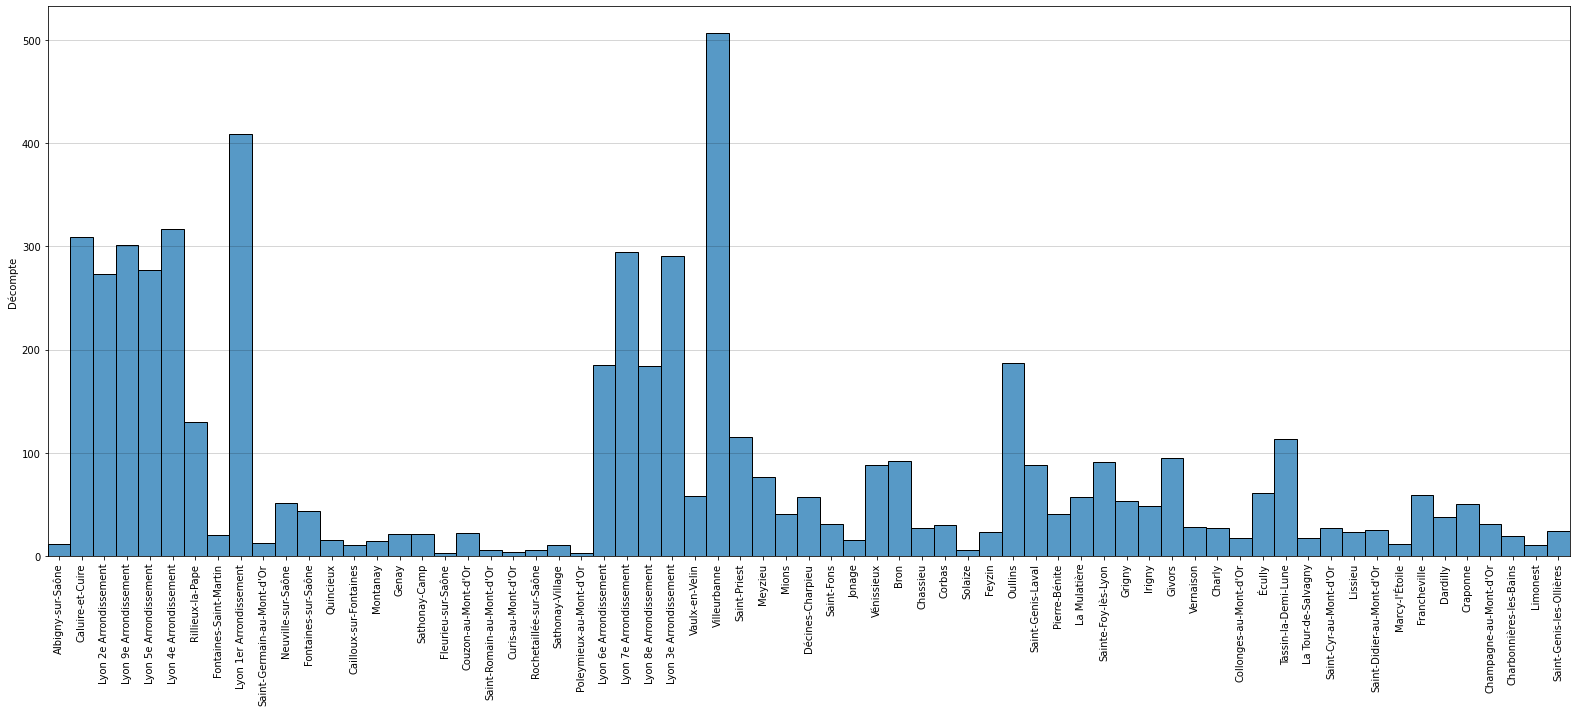

In [21]:
fig, ax = plt.subplots(figsize=(22,10))

sns.histplot(data=mut_mlyon, x="nom_commune", ax=ax)
ax.set_ylabel("Décompte")
ax.set_xlabel("")
ax.xaxis.set_tick_params(rotation=90)
ax.margins(x=0)
ax.grid(color='#000000', alpha=.2, which='major', axis='y', linestyle='solid')
fig.tight_layout()
plt.savefig("hist_mlyon2.jpg", dpi=300);

Le nombre de ventes varie beaucoup entre communes, on va donc prévoir une nouvelle colonne de décompte, qui sera pour l'instant égale à 1 partout !

In [22]:
mut_mlyon["decompte"]=1

# Transformation des données en mode pivot

On va maintenant passer à des regroupements de données, en passant en mode "[tableau croisé dynamique](https://fr.wikipedia.org/wiki/Tableau_crois%C3%A9_dynamique)". Cela se fait les doigts dans le nez avec pandas, grâce à [la méthode pivot()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html).

Démonstration avec :
* le regroupement **par commune et type de biens** 
* la distribution des médianes de valeurs foncières selon le bien **dans des colonnes distinctes**

In [23]:
test1 = mut_mlyon.groupby(["nom_commune","code_commune","type_local"]).agg({"prix_m2":lambda x: round(x.median(),2)}).reset_index()
test1 = test1.pivot(index=["code_commune","nom_commune"], columns="type_local", values="prix_m2").reset_index()
test1.rename(columns={"Appartement":"p_appart","Maison":"p_maison"}, inplace=True)
test1

type_local,code_commune,nom_commune,p_appart,p_maison
0,69003,Albigny-sur-Saône,2632.0,3816.0
1,69029,Bron,2597.5,4561.5
2,69033,Cailloux-sur-Fontaines,3724.0,4409.5
3,69034,Caluire-et-Cuire,3694.5,5724.0
4,69040,Champagne-au-Mont-d'Or,3088.0,5237.5
...,...,...,...,...
62,69385,Lyon 5e Arrondissement,3879.5,5121.0
63,69386,Lyon 6e Arrondissement,6296.0,NaN
64,69387,Lyon 7e Arrondissement,4923.0,5467.0
65,69388,Lyon 8e Arrondissement,3976.5,6213.0


On part ensuite sur un autre TCD, cette fois en additionnant les ventes par ville et type de bien. Merci la colonne de décompte !

In [24]:
test2 =  mut_mlyon.groupby(["code_commune","nom_commune","type_local"]).agg({"decompte":lambda x: sum(x)}).reset_index()
test2 = test2.pivot(index=["code_commune","nom_commune"], columns="type_local", values="decompte").reset_index()
test2.rename(columns={"Appartement":"d_appart","Maison":"d_maison"}, inplace=True)
test2.fillna(0, inplace=True)
test2["d_appart"]=test2["d_appart"].astype(int)
test2["d_maison"]=test2["d_maison"].astype(int)
test2

type_local,code_commune,nom_commune,d_appart,d_maison
0,69003,Albigny-sur-Saône,4,8
1,69029,Bron,54,38
2,69033,Cailloux-sur-Fontaines,1,10
3,69034,Caluire-et-Cuire,262,47
4,69040,Champagne-au-Mont-d'Or,21,10
...,...,...,...,...
62,69385,Lyon 5e Arrondissement,248,29
63,69386,Lyon 6e Arrondissement,185,0
64,69387,Lyon 7e Arrondissement,291,3
65,69388,Lyon 8e Arrondissement,156,28


Et on peut fusionner ces deux DF en une seule, grâce aux identifiants et noms de communes :

In [25]:
test = test1.merge(test2, on=["code_commune","nom_commune"])
test

type_local,code_commune,nom_commune,p_appart,p_maison,d_appart,d_maison
0,69003,Albigny-sur-Saône,2632.0,3816.0,4,8
1,69029,Bron,2597.5,4561.5,54,38
2,69033,Cailloux-sur-Fontaines,3724.0,4409.5,1,10
3,69034,Caluire-et-Cuire,3694.5,5724.0,262,47
4,69040,Champagne-au-Mont-d'Or,3088.0,5237.5,21,10
...,...,...,...,...,...,...
62,69385,Lyon 5e Arrondissement,3879.5,5121.0,248,29
63,69386,Lyon 6e Arrondissement,6296.0,NaN,185,0
64,69387,Lyon 7e Arrondissement,4923.0,5467.0,291,3
65,69388,Lyon 8e Arrondissement,3976.5,6213.0,156,28


# Plusieurs colonnes en une

Une amélioration pas mal du travail précédent pourrait être de rassembler les quatre valeurs en une même colonne, nommée selon l'année :

In [26]:
def prix_dico(x):
    for pa, pm, da, dm in zip(x["p_appart"],x["p_maison"],x["d_appart"],x["d_maison"]):
        dic = {"p_appart":pa,"p_maison":pm,"d_appart":da,"d_maison":dm}
    return dic

DF_remplissage=test.groupby(by=["code_commune","nom_commune"]).apply(prix_dico).reset_index()
DF_remplissage.rename(columns={0:"2020"}, inplace=True)
DF_remplissage

,code_commune,nom_commune,2020
0,69003,Albigny-sur-Saône,"{'p_appart': 2632.0, 'p_maison': 3816.0, 'd_ap..."
1,69029,Bron,"{'p_appart': 2597.5, 'p_maison': 4561.5, 'd_ap..."
2,69033,Cailloux-sur-Fontaines,"{'p_appart': 3724.0, 'p_maison': 4409.5, 'd_ap..."
3,69034,Caluire-et-Cuire,"{'p_appart': 3694.5, 'p_maison': 5724.0, 'd_ap..."
4,69040,Champagne-au-Mont-d'Or,"{'p_appart': 3088.0, 'p_maison': 5237.5, 'd_ap..."
...,...,...,...
62,69385,Lyon 5e Arrondissement,"{'p_appart': 3879.5, 'p_maison': 5121.0, 'd_ap..."
63,69386,Lyon 6e Arrondissement,"{'p_appart': 6296.0, 'p_maison': nan, 'd_appar..."
64,69387,Lyon 7e Arrondissement,"{'p_appart': 4923.0, 'p_maison': 5467.0, 'd_ap..."
65,69388,Lyon 8e Arrondissement,"{'p_appart': 3976.5, 'p_maison': 6213.0, 'd_ap..."


On peut continuer gaiement cette automatisation avec le paramétrage d'une classe dédiée. On l'initialise avec :
* un **département**
* une **liste de villes** (sur le modèle de ce qu'on a fait avec la Métropole de Lyon)
* une liste d'années basique : **au moins une année**, ou **une année de début et une année de fin** (dans l'ordre décroissant)
* une **liste de biens** (*Maison*, *Appartement*, etc)
* une **liste de mutations** (*Vente*, etc)

Les différentes fonctions reprennent l'essentiel de ce qui a été décrit avant, auxquelles on a ajouté trois fonctions :
* un **recyclage de la fonction prix_dico**, qui utilise la liste de biens pour agréger prix et décompte respectifs
* une **fonction lambda de rassemblement**, qui transforme (à partir de la liste d'années) les colonnes nommées en grand dictionnaire sur le schéma {annee:{'p_appart': n1, 'p_maison':n2, 'd_appart': n3, 'd_maison':n4}\[...\]}. En gros, objet d'objets **idéal dans un fichier json**
* une fonction **qui va créer plusieurs DataFrames (une par année)** et rassembler ensuite les chiffres de chaque année à partir de de la précédente

Bref, voici la bête :

In [43]:
class HorizonVF:
    def __init__(self, departement:int, l_villes:list, l_annees:list, l_biens:list, l_mutations:list):
        """
            L'initialisation d'un objet HorizonVF requiert un département, une liste de villes, une
            liste d'années.
        """
        self.departement = departement
        self.l_villes = l_villes
        self.l_annees = l_annees
        self.l_biens = l_biens
        self.l_mutations = l_mutations

    def selec_dep(self, annee:int):
        DF = pd.read_csv(r"https://files.data.gouv.fr/geo-dvf/latest/csv/"+str(annee)+"/full.csv.gz", encoding="UTF-8", low_memory=False)
        DF = DF[['id_mutation', 'nature_mutation', 'code_commune', 'nom_commune', 'code_departement',
                   'id_parcelle', 'ancien_id_parcelle', 'code_type_local', 'type_local', 
                   'valeur_fonciere','surface_reelle_bati', 'surface_terrain', 'longitude', 'latitude']]
        DF.drop_duplicates(subset="id_mutation",keep=False,inplace=True,ignore_index=True)
        DF["code_commune"] = DF["code_commune"].astype(str).str.rjust(5,"0")
        DF["code_departement"] = DF["code_departement"].astype(str).str.rjust(2,"0")
        DF = DF[DF["code_departement"] == str(self.departement)]
        DF = DF[(DF["nature_mutation"].isin(self.l_mutations)) & (DF["type_local"].isin(self.l_biens))]
        DF = DF.reset_index()
        DF.drop(columns="index",inplace=True)
        return DF

    def selec_villes(self, annee:int):
        """
            Cette fonction renvoie une DataFrame qui contient toutes les données relatives aux
            biens scrutés pour une ville présente dans la liste soumise lors de l'initialisation
            d'un HorizonDF.
        """
        DF = self.selec_dep(annee)
        DF = DF[(DF["code_commune"].isin(self.l_villes))]
        DF.dropna(subset=["valeur_fonciere","surface_reelle_bati"], inplace=True)
        return DF
    
    def prix_annee(self,DF):
        """
            Cette fonction renvoie une DataFrame avec les prix et décomptes de chaque type
            de bien retenu, colonnes respectivement nommées p_type et d_type
        """
        DF.dropna(subset=["valeur_fonciere","surface_reelle_bati"], inplace=True)
        DF["prix_m2"]=round(DF["valeur_fonciere"].astype(float)/DF["surface_reelle_bati"].astype(float)).astype(int)
        DF["decompte"]=1
        types=list(DF["type_local"].unique())
        DF1 = DF.groupby(["nom_commune","code_commune","type_local"]).agg({"prix_m2":lambda x: round(x.median(),2)}).reset_index()
        DF1 = DF1.pivot(index=["code_commune","nom_commune"], columns="type_local", values="prix_m2").reset_index()
        DF1.rename(columns={t:"p_"+str(t).split(" ")[0].lower() for t in types}, inplace=True)
        DF1.fillna(0, inplace=True)
        for t in types:
            DF1["p_"+str(t).split(" ")[0].lower()]=DF1["p_"+str(t).split(" ")[0].lower()].astype(int)
        DF2 =  DF.groupby(["code_commune","nom_commune","type_local"]).agg({"decompte":lambda x: sum(x)}).reset_index()
        DF2 = DF2.pivot(index=["code_commune","nom_commune"], columns="type_local", values="decompte").reset_index()
        DF2.rename(columns={t:"d_"+str(t).split(" ")[0].lower() for t in types}, inplace=True)
        DF2.fillna(0, inplace=True)
        for t in types:
            DF2["d_"+str(t).split(" ")[0].lower()]=DF2["d_"+str(t).split(" ")[0].lower()].astype(int)
        DF = DF1.merge(DF2, on=["code_commune","nom_commune"])
        return DF

    def prix_dico(self,x):
        """
            Cette fonction renvoie, à partir de la liste de biens renseignée par l'utilisateur,
            un dico avec prix médian et décompte de chaque type. Objectif : rassembler ces
            informations par année
        """
        liste_types = [u.split(" ")[0].lower() for u in self.l_biens]
        dic = {}
        for t in liste_types:
            dic["p_"+t]=int(x["p_"+t].iloc[0])
            dic["d_"+t]=int(x["d_"+t].iloc[0])
        return dic    

    def histo_prix(self):
        """
            Cette fonction renvoie un dictionnaire qui agrège des colonnes correspondant
            à des années. Objectif : agréger toutes les années et chiffres de biens
            dans une seule colonne
        """
        DF=self.selec_villes(self.l_annees[0])
        DF=self.prix_annee(DF)
        DF=DF.groupby(by=["code_commune","nom_commune"]).apply(self.prix_dico).reset_index(name=self.l_annees[0])
        if len(self.l_annees)>1:
            for i in range(self.l_annees[0]-1,self.l_annees[1],-1):
                DF_trans=self.selec_villes(i)
                DF_trans=self.prix_annee(DF_trans)
                DF_trans=DF_trans.groupby(by=["code_commune","nom_commune"]).apply(self.prix_dico).reset_index(name=i)
                DF= DF.merge(DF_trans, on=["code_commune","nom_commune"])
        DF = DF.set_index(["code_commune","nom_commune"])
        DF=DF.apply(lambda x: {f'{col}':x[col] for col in range(self.l_annees[0],self.l_annees[1],-1)}, 1).reset_index(name="histo_prix")
        return DF

Cette classe va nous permettre de retomber sur nos pattes vite fait bien, fait :

In [44]:
DF_MLyon = HorizonVF(69, metropole_lyon, [2020,2015], ["Maison","Appartement"],["Vente"])
# les lignes suivante sont juste pour vérifier que tout est conforme aux manips précédentes
#transac_lyon = DF_MLyon.selec_villes(2020)
#len(transac_lyon)

In [45]:
#t2020 = DF_MLyon.prix_annee(transac_lyon)
#t2020

Le moment de vérité est arrivé : dresser l'historique des prix entre 2016 et 2020 :

In [46]:
histo_mlyon=DF_MLyon.histo_prix()

Afin de faciliter la fusion avec des fichiers géographiques à venir, on va renommer deux colonnes :

In [48]:
histo_mlyon.rename(columns={"code_commune":"insee","nom_commune":"nom"}, inplace=True)
histo_mlyon.tail()

,insee,nom,histo_prix
62,69385,Lyon 5e Arrondissement,"{'2020': {'p_maison': 5121, 'd_maison': 29, 'p..."
63,69386,Lyon 6e Arrondissement,"{'2020': {'p_maison': 0, 'd_maison': 0, 'p_app..."
64,69387,Lyon 7e Arrondissement,"{'2020': {'p_maison': 5467, 'd_maison': 3, 'p_..."
65,69388,Lyon 8e Arrondissement,"{'2020': {'p_maison': 6213, 'd_maison': 28, 'p..."
66,69389,Lyon 9e Arrondissement,"{'2020': {'p_maison': 5166, 'd_maison': 15, 'p..."


# Préparation des fichiers géographiques

## Jointure avec les communes ou arrondissements de Lyon

Le principal fichier géographique est composé des communes ou arrondissements de la métropole, enrichies avec les données produites avant. Il s'agit surtout **de faire une jointure sur un champ commun**.

D'abord, on utilise un fichier géographique brut (là j'ai quelque chose de tout prêt bricolé avec le logiciel QGIS pour avoir les communes hors Lyon + les arrondissements) :

In [33]:
communes_mlyon = gpd.read_file("C:/Users/Rapha/Documents/Data/Geographie/France/Rhone/Lyon/Métropole/metropole_lyon.json")
communes_mlyon.drop(columns=["nom"], inplace=True)
communes_mlyon.head()

,insee,geometry
0,69003,"MULTIPOLYGON (((4.81766 45.85600, 4.81958 45.8..."
1,69029,"MULTIPOLYGON (((4.88673 45.72932, 4.89214 45.7..."
2,69033,"MULTIPOLYGON (((4.85449 45.85609, 4.85624 45.8..."
3,69034,"MULTIPOLYGON (((4.81892 45.78973, 4.82294 45.7..."
4,69040,"MULTIPOLYGON (((4.77028 45.80083, 4.77062 45.8..."


On fusionne ceci avec la DataFrame précédente :

In [34]:
geo_immo_lyon = histo_mlyon.merge(communes_mlyon, on="insee")
geo_immo_lyon.tail()

,insee,nom,histo_prix,geometry
62,69385,Lyon 5e Arrondissement,"{'2020': {'p_maison': 5121, 'd_maison': 29, 'p...","MULTIPOLYGON (((4.81353 45.74819, 4.81339 45.7..."
63,69386,Lyon 6e Arrondissement,"{'2020': {'p_maison': 0, 'd_maison': 0, 'p_app...","MULTIPOLYGON (((4.86994 45.76373, 4.83980 45.7..."
64,69387,Lyon 7e Arrondissement,"{'2020': {'p_maison': 5467, 'd_maison': 3, 'p_...","MULTIPOLYGON (((4.83770 45.70737, 4.83444 45.7..."
65,69388,Lyon 8e Arrondissement,"{'2020': {'p_maison': 6213, 'd_maison': 28, 'p...","MULTIPOLYGON (((4.84879 45.71885, 4.84852 45.7..."
66,69389,Lyon 9e Arrondissement,"{'2020': {'p_maison': 5166, 'd_maison': 15, 'p...","MULTIPOLYGON (((4.81088 45.78099, 4.80927 45.7..."


On transforme cette DataFrame en GeoDataFrame :

In [35]:
geo_immo_lyon = gpd.GeoDataFrame(geo_immo_lyon, geometry=geo_immo_lyon["geometry"])

Tout est prêt, plus qu'à enregistrer dans un dossier dédié :

In [36]:
geo_immo_lyon.to_file("data/immo_lyon.json", driver="GeoJSON")

## Contours des communes de la Métropole de Lyon

On va produire un calque simple avec les contours des communes composant la Métropole de Lyon. D'abord, on charge l'ensemble des communes du pays grâce aux données fournies par OpenStreetMap :

In [2]:
communes = gpd.read_file("https://osm13.openstreetmap.fr/~cquest/openfla/export/communes-20210101-shp.zip")
communes.drop(columns=["wikipedia","surf_ha"], inplace=True)
communes.head()

,insee,nom,geometry
0,30225,Sabran,"POLYGON ((4.49703 44.14344, 4.49727 44.14398, ..."
1,26334,Salettes,"POLYGON ((4.94213 44.57481, 4.94283 44.57501, ..."
2,04200,Salignac,"POLYGON ((5.95337 44.15613, 5.95341 44.15649, ..."
3,04179,Saint-Geniez,"POLYGON ((5.98593 44.23280, 5.98654 44.23292, ..."
4,05162,La Saulce,"POLYGON ((5.98920 44.41892, 5.98921 44.41894, ..."


Puis, on ne retient que celles appartenant à la Métropole de Lyon. Rappel : **leurs codes INSEE sont stockés dans la liste com_mlyon**, qu'on avait réservée avant :

In [119]:
communes_mylon=communes[communes["insee"].isin(com_mlyon)].reset_index()
communes_mylon.drop(columns="index",inplace=True)
communes_mylon.tail()

,insee,nom,geometry
54,69204,Saint-Genis-Laval,"POLYGON ((4.76438 45.68979, 4.76515 45.69081, ..."
55,69091,Givors,"POLYGON ((4.70349 45.58795, 4.70351 45.58799, ..."
56,69029,Bron,"POLYGON ((4.88673 45.72932, 4.88676 45.72949, ..."
57,69085,Fleurieu-sur-Saône,"POLYGON ((4.83656 45.85188, 4.83670 45.85277, ..."
58,69273,Corbas,"POLYGON ((4.88635 45.67162, 4.88973 45.67816, ..."


Enfin :
* on simplifie la géométrie afin d'alléger le fichier final
* on ne retient que les contours
* on sauvegarde dans le dossier dédié

Trois instructions, trois lignes !

In [120]:
communes_mylon["geometry"]=communes_mylon["geometry"].simplify(.00003)
contours = communes_mylon.boundary
contours.to_file("data/contours.json", driver="GeoJSON")

## Dernier fichier : marquer Lyon

On a enregistré des polygones, puis des lignes, à présent on va préparer des points. Ou plutôt un seul point, qui situera nommément la ville de Lyon.

On va pour cela réutiliser la GeoDataFrame communes, n'y sélectionner que la ville de Lyon, et transformer ce polygone en point en établissant son barycentre ([ou centroïde](https://geopandas.org/docs/user_guide/geometric_manipulations.html)).

In [132]:
lyon = communes[communes["nom"]=="Lyon"].copy()
lyon.drop(columns="insee",inplace=True)
lyon["geometry"]=lyon["geometry"].centroid
lyon

<ipython-input-132-c94562affc8d>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lyon["geometry"]=lyon["geometry"].centroid


,nom,geometry
678,Lyon,POINT (4.83635 45.75493)


Et plus qu'à enregistrer ce dernier fichier dans le dossier data :

In [134]:
lyon.to_file("data/villes.json", driver="GeoJSON")